# Times Series with GARCH

In [1]:
# Installations 
from arch import arch_model
from statsmodels.tsa.stattools import adfuller,q_stat,acf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import pandas as pd
import numpy as np 
from pathlib import Path
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
import glob
import cufflinks as cf
import scipy
import scipy.stats as stats
import scipy.optimize as sp_optimize
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.tsa.statespace.varmax import VARMAX, VARMAXResults
from statsmodels.tsa.statespace.kalman_filter import FilterResults
import plotly.graph_objects as go

In [2]:
# Imports
plt.style.use("seaborn")
cf.set_config_file(offline = True)
%matplotlib inline
cf.set_config_file(offline = True)

# Extracting Data from Google Finance
## Step 1
1. Using SP500 to predict market volatility 



In [3]:
# Load one of the indices and clean the data


index_path = './DATA/INDICES/SP_OHLCV.csv'
def load_index(path):
    
    df = pd.read_csv(path, parse_dates=True, infer_datetime_format=True, index_col="Date" )
    df['Return'] = df.Close.pct_change().dropna()

 
    # dropna's and display data     
    df.dropna(inplace=True)
    print(df.shape)
    print('Data loaded')
    display(df.head(3))
    display(df.tail(3))
    
    return df

df_SP = load_index(index_path)
df_SP.loc["5-2022":"9-2022"].iplot(kind="candle",fill = True, colorscale="paired", theme="solar",
              title="SP500", xTitle= "Time", yTitle= "Stock Price");

(3025, 6)
Data loaded


,Open,High,Low,Close,Volume,Return
Date,,,,,,
2010-10-06,1159.81,1162.33,1154.85,1159.97,0,-0.000672
2010-10-07,1161.57,1163.87,1151.41,1158.06,391055008,-0.001647
2010-10-08,1158.36,1167.73,1155.58,1165.15,387142016,0.006122


,Open,High,Low,Close,Volume,Return
Date,,,,,,
2022-09-28,3651.94,3736.74,3640.61,3719.04,2637914627,0.019672
2022-09-29,3687.01,3687.01,3610.40,3640.47,2601213630,-0.021126
2022-09-30,3633.48,3671.44,3584.13,3585.62,3146085245,-0.015067


In [4]:
# check info
df_SP.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3025 entries, 2010-10-06 to 2022-09-30
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    3025 non-null   float64
 1   High    3025 non-null   float64
 2   Low     3025 non-null   float64
 3   Close   3025 non-null   float64
 4   Volume  3025 non-null   int64  
 5   Return  3025 non-null   float64
dtypes: float64(5), int64(1)
memory usage: 230.0 KB


In [5]:
# check missing value 
df_SP.isna().sum()

Open      0
High      0
Low       0
Close     0
Volume    0
Return    0
dtype: int64

# Step 2
## Check for Stationarity 
1. A Stationary in time series is one whose mean and variance does not change over time
2. perform augmentation testing Dickey-Fuller Test (ADF Test)
- Ho (Null Hypothesis): The time series data is non-stationary
- H1 (alternate Hypothesis): The time series data is stationary
- p-value > 0.05: Fail to reject the null hypothesis (H0), the data has a unit root and is non-stationary.
- p-value <= 0.05: Reject the null hypothesis (H0), the data does not have a unit root and is stationary.



In [6]:
# Check stationarity
# fix stationarity by apply log and diff
df_transformed = pd.DataFrame({'Open': np.log(df_SP.Open).diff(),
                              'High': np.log(df_SP.High).diff(),
                               'Low': np.log(df_SP.Low).diff(),
                               'Close': np.log(df_SP.Close).diff(),
                               'Volume':np.log(df_SP.Volume).diff(),
                               'Return':np.log(df_SP.Return).diff()
                               
                              }).rename(columns={
                                'Open':"log_Open",
                                'High': 'log_High',
                                'Low': "log_Low",
                                'Close':'log_Close',
                                'Volume': 'log_volume',
                                'Return': 'log_Return'}).dropna()                                                                                       
                                 
display(df_transformed.head())
df_transformed.log_Close.iplot(fill = True, colorscale="polar", theme="solar",
              title="SP500", xTitle= "Time", yTitle= "Stock Price");

,log_Open,log_High,log_Low,log_Close,log_volume,log_Return
Date,,,,,,
2010-10-11,0.005991,0.000813,0.005557,0.000146,-0.434973,-3.736746
2010-10-12,-0.000893,0.003332,-0.005445,0.003811,0.486510,3.264715
2010-10-13,0.006028,0.010013,0.013416,0.007096,0.198143,0.623148
2010-10-18,-0.000544,0.003659,0.006346,0.007218,-0.251912,1.273290
2010-10-21,0.011148,0.005471,0.003790,0.001772,-0.083420,-1.780462


In [7]:
df_transformed.isna().sum()

log_Open      0
log_High      0
log_Low       0
log_Close     0
log_volume    0
log_Return    0
dtype: int64

In [8]:
# reset date column
df_SP.reset_index("Date")

# save a dataframe to new csv called Dickey_Fuller 
df_SP.to_csv("Dickey-Fuller-Test.csv")

# set header and index_col = 0
df_SP_Test = pd.read_csv("Dickey-Fuller-Test.csv", header=0, index_col=0)

# get values of our dataframe then reshape it to 1 dimentional array to be fitted into adfuller model 
values = df_SP_Test.values.reshape(-1)

# results 
res = adfuller(values)

# print results 
print('Augmneted Dickey_fuller Statistic: %f' % res[0])
print('p-value: %f' % res[1])
print('critical values at different levels:')
for k, v in res[4].items():
    print('\t%s: %.3f' % (k, v))

Augmneted Dickey_fuller Statistic: -3.625497
p-value: 0.005292
critical values at different levels:
	1%: -3.431
	5%: -2.862
	10%: -2.567


In [9]:
# if p value > alpha level, probably null is true (non-stationary)
# ADF statistiscs is higher than critical values, then non-stationary

In [10]:
'''
our results show that Dickey_fuller Statistic is greater than critical values of 1%,5%,10% 
p-value is less than 0.05
so, we proved the stationarity 

'''

'\nour results show that Dickey_fuller Statistic is greater than critical values of 1%,5%,10% \np-value is less than 0.05\nso, we proved the stationarity \n\n'

# Calculating volatility for SP500

In [11]:
# Resample daily datat
df_transformed['log_Return'] = df_transformed['log_Close'] - df_transformed['log_Close'].shift(1)
df_transformed['squared_log_Return'] = np.power(df_transformed['log_Return'], 2)
df_transformed.dropna(inplace=True)

In [12]:
# Calculate daily std of returns
std_daily = df_SP['Return'].std()

print(f'Daily volatility: {round(std_daily,5)}%')

# Convert daily volatility to monthly volatility
std_monthly = np.sqrt(21) * std_daily

print(f'\nMonthly volatility: {round(std_monthly,5)}%')

# Convert daily volatility to annaul volatility
std_annual = np.sqrt(252) * std_daily

print(f'\nAnnual volatility: {round(std_annual,5)}%')


Daily volatility: 0.01099%

Monthly volatility: 0.05038%

Annual volatility: 0.17453%


# Apply ACF & PACF plot to find the right q, p?

In [13]:
# check autocorrelation log_close 
df_transformed.log_Return.autocorr()

-0.5542594686192955

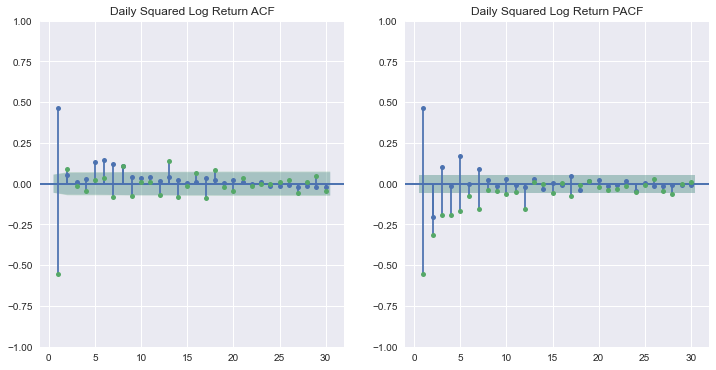

In [14]:
#fig, ax = plt.subplot()

fig, axes = plt.subplots(1, 2, figsize=(12, 6))
plot_acf(df_transformed['squared_log_Return'][1:],zero=False,alpha=0.1, title='Squared Daily Log Return ACF',ax=axes[0])
plot_acf(df_transformed['log_Return'][1:],zero=False,alpha=0.1, title='Daily Squared Log Return ACF',ax=axes[0])
plot_pacf(df_transformed['squared_log_Return'][1:],zero=False,alpha=0.1, title='Squared Daily Log Return PACF',ax=axes[1])
plot_pacf(df_transformed['log_Return'][1:],zero=False,alpha=0.1, title='Daily Squared Log Return PACF',ax=axes[1])
plt.show()

## Fit a Garch model ()  since we assumed our data is stationary
-  p = ?, q = ?

## Resample data by weekly return to get futher forcasting 

,log_Open,log_High,log_Low,log_Close,log_volume,log_Return,squared_log_Return
Date,,,,,,,
2010-10-24,0.003267,0.003568,0.004952,0.004457,-0.005208,0.000448,0.000011
2010-10-31,0.003568,0.003195,0.005078,0.003415,-0.065955,-0.000875,0.000008


,log_Open,log_High,log_Low,log_Close,log_volume,log_Return,squared_log_Return
Date,,,,,,,
2022-09-11,0.010019,0.008448,0.010140,0.008210,0.031322,-0.000442,0.00007
2022-09-18,0.010997,0.009677,0.011209,0.009628,0.021186,0.001313,0.00006


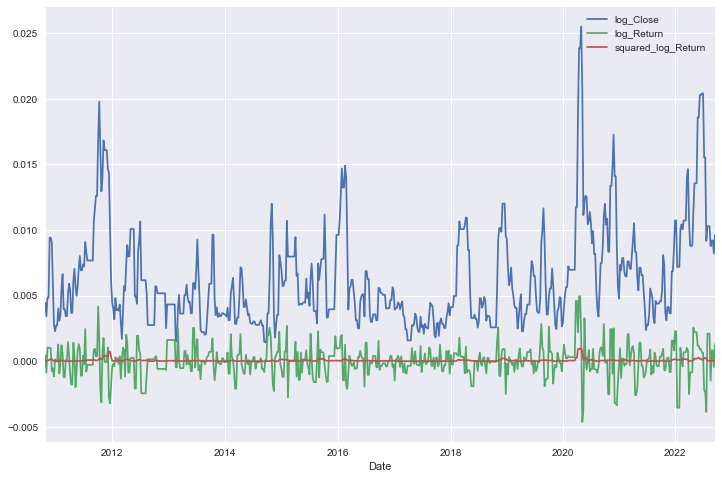

In [15]:
# Creating Garch dataframe of 5 day window by apply mean()
df_Garch = df_transformed.rolling(window=5).mean()

# dropna's
df_Garch.dropna(inplace=True)

# resample by weekly 
df_Garch = df_Garch.resample('W').mean()

# check if there is na's
df_Garch.fillna(method='ffill',inplace=True) 

# data frame
#print(df_Garch.shape)
display(df_Garch.head(2))
display(df_Garch.tail(2))
df_Garch.loc[:,['log_Close','log_Return','squared_log_Return']].plot(figsize=(12,8))
plt.show()

# Implement a basic GARCH model
1. to implement a GARCH(p,q) model:
- First defines basic GRACH(p,q) model
- train test split then fit model
- review the model fitting summary and plot the results

In [16]:
# apply train test split 
split = int(len(df_Garch) * 0.70)
df_train, df_test = df_Garch.iloc[:split], df_Garch.iloc[split:]
print(df_train.info())  
print(df_test.info()) 

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 435 entries, 2010-10-24 to 2019-02-17
Freq: W-SUN
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   log_Open            435 non-null    float64
 1   log_High            435 non-null    float64
 2   log_Low             435 non-null    float64
 3   log_Close           435 non-null    float64
 4   log_volume          435 non-null    float64
 5   log_Return          435 non-null    float64
 6   squared_log_Return  435 non-null    float64
dtypes: float64(7)
memory usage: 27.2 KB
None
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 187 entries, 2019-02-24 to 2022-09-18
Freq: W-SUN
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   log_Open            187 non-null    float64
 1   log_High            187 non-null    float64
 2   log_Low             187 non-null    float6

In [17]:
# Using for loop to make a guess finding right p,q
for p in range(3):
    for q in range(3):
        if p == 0 and q == 0:
            continue
            
        print(f'Testing Order: p = {p}, q = {q}')

Testing Order: p = 0, q = 1
Testing Order: p = 0, q = 2
Testing Order: p = 1, q = 0
Testing Order: p = 1, q = 1
Testing Order: p = 1, q = 2
Testing Order: p = 2, q = 0
Testing Order: p = 2, q = 1
Testing Order: p = 2, q = 2


Inequality constraints incompatible    (Exit mode 4)
            Current function value: -3355.9660871794813
            Iterations: 1
            Function evaluations: 7
            Gradient evaluations: 1
                     Constant Mean - GARCH Model Results                      
Dep. Variable:             log_Return   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                3355.97
Distribution:                  Normal   AIC:                          -6699.93
Method:            Maximum Likelihood   BIC:                          -6673.33
                                        No. Observations:                  622
Date:                Wed, Oct 05 2022   Df Residuals:                      621
Time:                        14:08:14   Df Model:                            1
                                 Mean Model                                 
     

C:\Users\eszczepalink\anaconda3\lib\site-packages\arch\univariate\base.py:753: ConvergenceWarning:

The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.




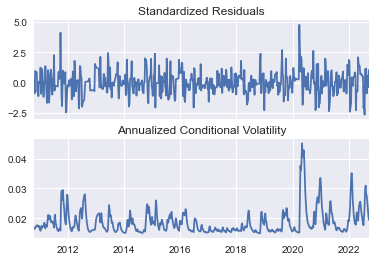

In [18]:
#GARCH model with constant mean
model = arch_model(df_Garch.log_Return, p = p, q = q,
                      mean = 'constant', vol = 'GARCH', dist = 'normal')
# Fit the model   freq to avoid display unnecessary value
result = model.fit(update_freq = 5)
 

# Display model fitting summary
print(result.summary())


# Plot fitted results
result.plot(annualize='D')
plt.show()


# Make forecast with GARCH models

In [19]:
df_Garch.index.max()

Timestamp('2022-09-18 00:00:00', freq='W-SUN')

                 h.1       h.2       h.3       h.4       h.5
Date                                                        
2022-09-18  0.000001  0.000001  0.000001  0.000001  0.000001


<AxesSubplot:>

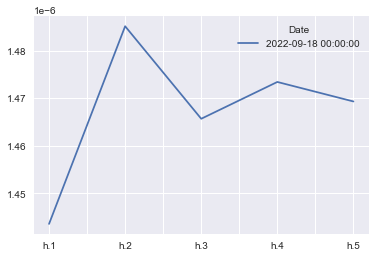

In [20]:
# horizon = how many observations we want our model to predict for each day 
# for each date, we'll get the predicted value, for the next date
pred_grach = result.forecast(start = "2022-09-18",horizon= 5)
# prediction value for next weeks
print(pred_grach.variance[-1:])
# plot prediction
pred_grach.variance[-1:].T.plot()

# Distribution assumptions
1. Volatility is not directly observed
2. GARCH model use residuals as volatilty shocks
3. Volatility is related to the residuals
### Residual = predicted return - mean return
  - Residual = predicted return - mean return
 
  - Standardized residual = residual / return volatility


# Plot distribution of standardized residuals

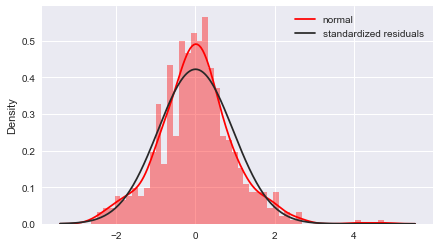

In [21]:
# residuals and volatility
model_resid = result.resid
model_std = result.conditional_volatility

# Calculate the standardized residuals
result_std = model_resid /model_std

# Plot the histogram of the standardized residuals
plt.figure(figsize=(7,4))
sns.distplot(result_std, norm_hist=True, fit=stats.norm, bins=50, color='r')
plt.legend(('normal', 'standardized residuals'))
plt.show()


# Fit a GARCH with skewed t-distribution
- We improve the GARCH model by using a skewed t-distribution

In [22]:
# Garch model skewt
model_garch_skewt = arch_model(df_Garch.log_Return, p = p, q = q,
                       mean = 'constant', vol = 'GARCH', dist = 'skewt')

# fit the model
model_garch_skewt_result = model_garch_skewt.fit(disp='off')

# get estimated volatility 
vol_Grch_model = model_garch_skewt_result.conditional_volatility

C:\Users\eszczepalink\anaconda3\lib\site-packages\arch\univariate\base.py:753: ConvergenceWarning:

The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.




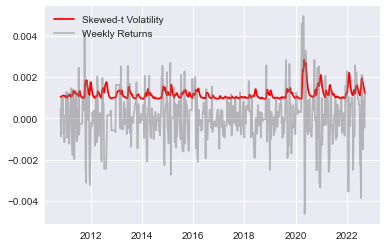

In [23]:
# Plot model fitting results
plt.plot(vol_Grch_model, color = 'red', label = 'Skewed-t Volatility')
plt.plot(df_Garch.log_Return, color = 'grey', 
         label = 'Weekly Returns', alpha = 0.5)
plt.legend(loc = 'upper left')
plt.show()

# Goodness of fit

1. Maximun likelihood
2. Lower Criteria (AIC, BIC)

In [24]:
# Print the Criteria (BIC) (AIC) of GARCH
print(f'GARCH BIC : { result.bic}')
print(f'GARCH AIC : { result.aic}')

# Print the log-likelihodd of GARCH
print('Log-likelihood of GARCH :', result.loglikelihood)
# Print the log-likelihodd of skewt GARCH
print('Log-likelihood of skewt GARCH :', model_garch_skewt_result.loglikelihood)

GARCH BIC : -6673.334533802527
GARCH AIC : -6699.932174358963
Log-likelihood of GARCH : 3355.9660871794813
Log-likelihood of skewt GARCH : 3367.709939519277


# Backtesting with MAE, MSE

-  Out of sample forecast

In [33]:
def evaluate(y_true, y_pred): 
    # calculate MAE
    mae = mean_absolute_error(y_true, y_pred)
    print(f'Mean Absolute Error (MAE): {round(mae,3)}')
    # calculate MSE
    mse = mean_squared_error(y_true, y_pred)
    print(f'Mean Squared Error (MSE): {round(mse,3)}')
    return mae, mse

In [26]:
# weekly resample, apply std then calculate y_true, y_pred
Garch_std = df_transformed.log_Return.rolling(window=5).std().dropna()
Garch_std = Garch_std.resample('W').std().fillna(0)
# out put 
y_true = Garch_std
y_pred = model_std

In [27]:
# print out mae
mean_absolute_error(y_true,y_pred)

0.0010623459146684733

In [28]:
# print out mse
mean_squared_error(y_true,y_pred)

1.7190893438081998e-06